# Salary Predictions Based on Job Descriptions

## Problem Statment 

Predict the salary of an individual using data about prior individuals and their job descriptions

In [1]:
#import your libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge

import warnings
warnings.filterwarnings('ignore')

__author__ = "Vijay Raj Saravanan Radhakrishnan"
__email__ = "vijay_saravanan@outlook.com"

## Part 2 - DISCOVER

In [2]:
#load the data into a Pandas dataframe
feature_data = pd.read_csv("data/train_features.csv")
target_data = pd.read_csv("data/train_salaries.csv")
Total_data = pd.merge(feature_data, target_data, how="inner", on="jobId")
train, test = train_test_split(Total_data, test_size = 0.2)


In [3]:
train.shape

(800000, 9)

In [4]:
train.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800000 entries, 851258 to 312485
Data columns (total 9 columns):
jobId                  800000 non-null object
companyId              800000 non-null object
jobType                800000 non-null object
degree                 800000 non-null object
major                  800000 non-null object
industry               800000 non-null object
yearsExperience        800000 non-null int64
milesFromMetropolis    800000 non-null int64
salary                 800000 non-null int64
dtypes: int64(3), object(6)
memory usage: 61.0+ MB


In [5]:
train.describe()

,yearsExperience,milesFromMetropolis,salary
count,800000.00000,800000.000000,800000.000000
mean,11.98979,49.517902,116.037875
std,7.21157,28.872776,38.710306
min,0.00000,0.000000,0.000000
25%,6.00000,25.000000,88.000000
50%,12.00000,50.000000,114.000000
75%,18.00000,74.000000,141.000000
max,24.00000,99.000000,301.000000


In [6]:
train.describe(include=["O"])

,jobId,companyId,jobType,degree,major,industry
count,800000,800000,800000,800000,800000,800000
unique,800000,63,8,5,9,7
top,JOB1362684473765,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,12987,100952,189700,426131,114520


### ---- 3 Clean the data ----

In [7]:
train.duplicated().sum()

0

In [8]:
def standard_column_names(df):
    existing_columns = list(df.columns.values)
    standardized_names = [column_name.lower() for column_name in existing_columns]
    df.columns = standardized_names

In [9]:
categ_features = ["companyid", "jobtype", "degree", "major", "industry"]
num_features = ["milesfrommetropolis", "yearsexperience"]
def convert_to_category(df):
    for cat_feature in categ_features:
        df[cat_feature] = df[cat_feature].astype("category")


In [10]:
standard_column_names(train)
standard_column_names(test)
convert_to_category(train)
convert_to_category(test)

### ---- 4 Explore the data (EDA) ----

In [11]:
def visualize_relationship(df, feature):
    if df[feature].dtype.name == "category":
        if feature == "companyId":
            pass
        elif feature == "salary":
            plt.hist(df[feature])
            plt.xlabel("Salary")
            plt.ylabel("Frequency")
        else:
            plt.figure(figsize=(16,8))
            plt.subplot(121)
            sb.countplot(data=df, x=feature)
            plt.xlabel(feature.capitalize())
            plt.ylabel("Frequency")
            plt.xticks(rotation=45)
            
            plt.subplot(122)
            sb.boxplot(df[feature], df["salary"])
            plt.xticks(rotation = 45)
            
                         
    if df[feature].dtype.name == "int64":
        plt.figure(figsize=(16, 8))
        plt.subplot(121)
        plt.hist(df[feature])
        plt.xlabel(feature.capitalize())
        plt.ylabel("Frequency")
        
        plt.subplot(122)
        plt.scatter(df[feature], df["salary"], alpha=0.2)
        plt.xlabel(feature.capitalize())
        plt.ylabel("Salary")
        plt.title("{} vs {}".format("Salary", feature.capitalize()))

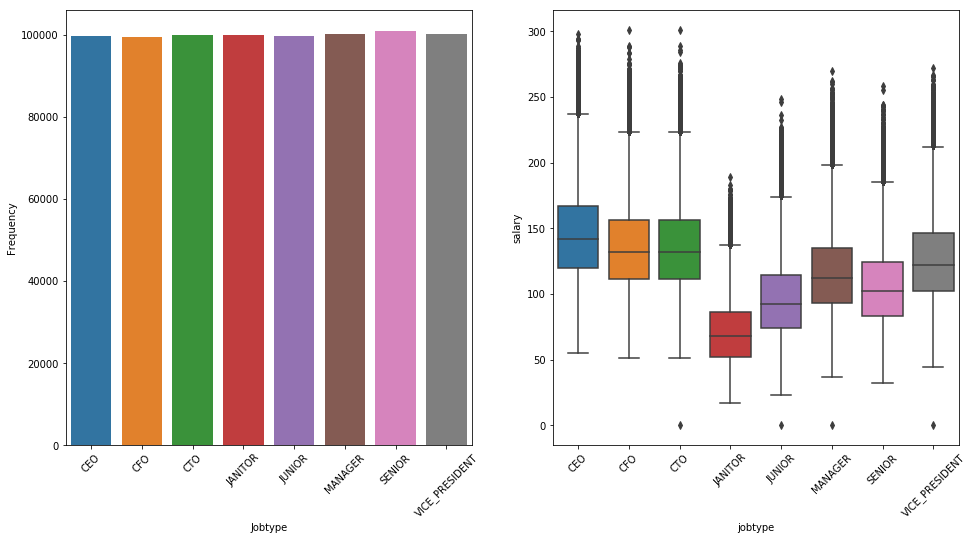

In [12]:
visualize_relationship(train, "jobtype")

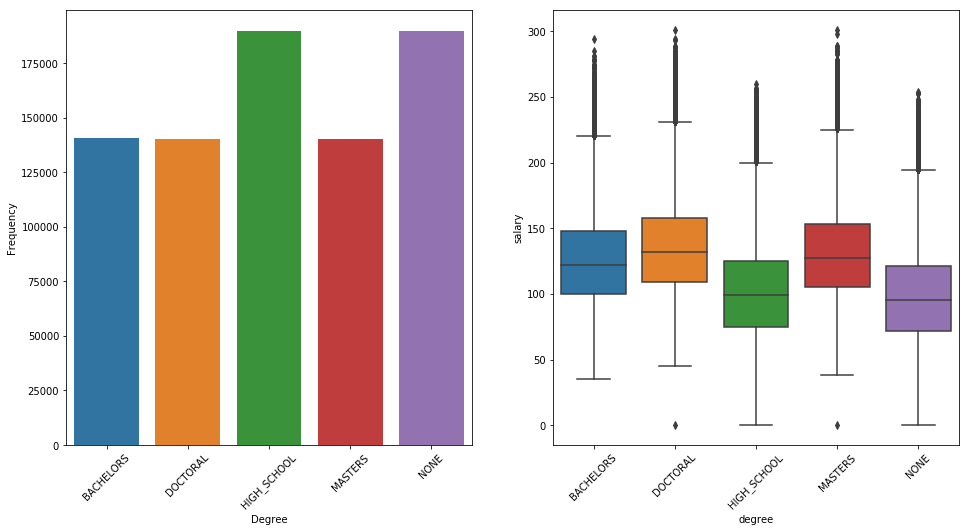

In [13]:
visualize_relationship(train, "degree")

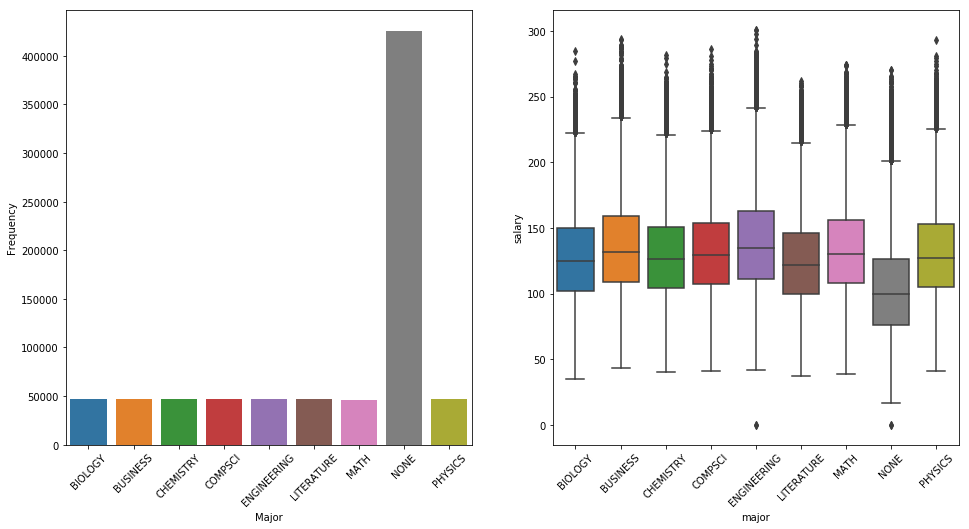

In [14]:
visualize_relationship(train, "major")

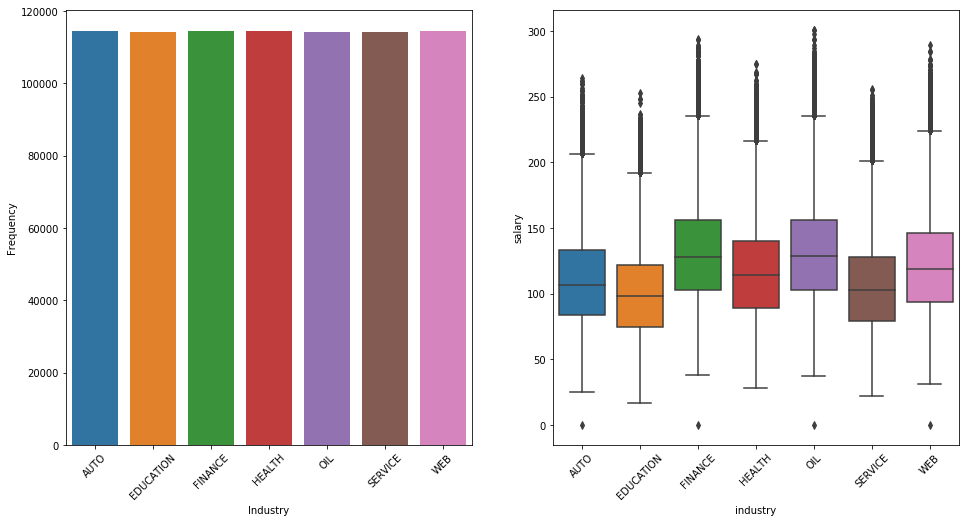

In [15]:
visualize_relationship(train, "industry")

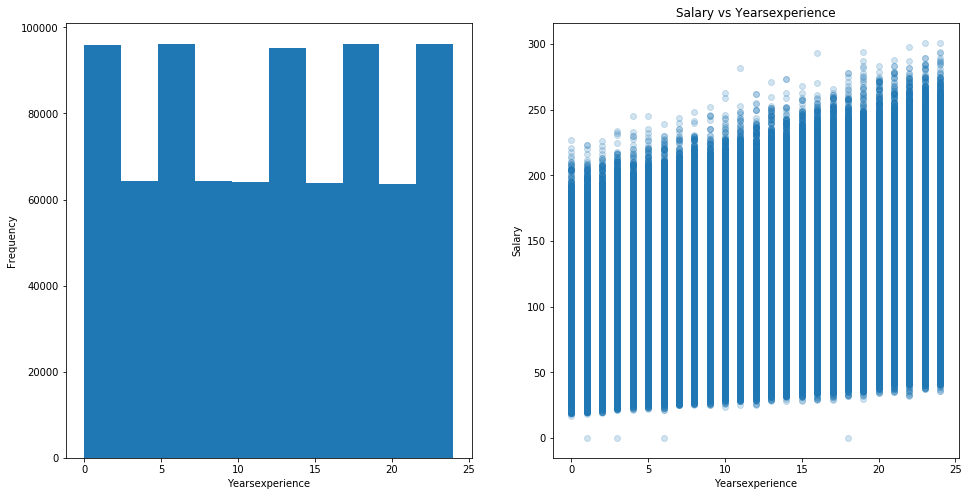

In [16]:
visualize_relationship(train, "yearsexperience")

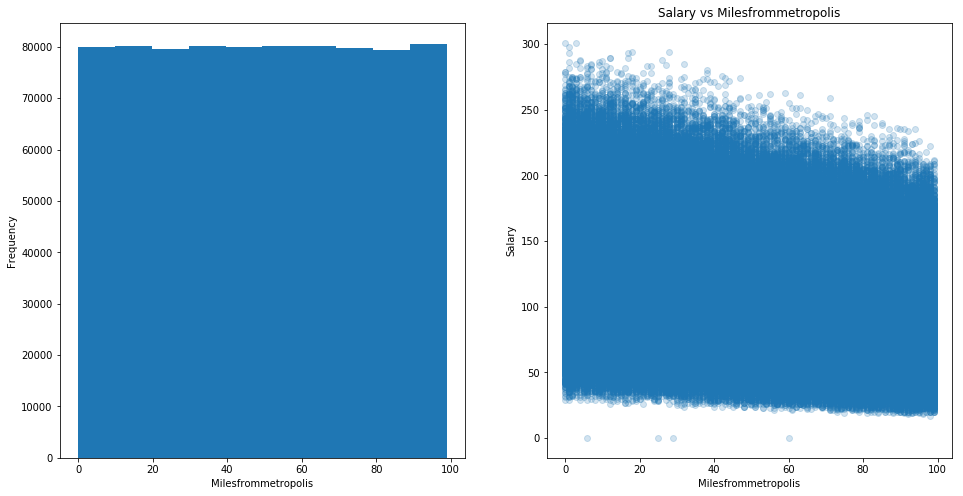

In [17]:
visualize_relationship(train, "milesfrommetropolis")

## Pipeline

In [18]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.attributes = attributes
    def fit(self, X, y=None):
        return self
    def transform(self, df):
        return df[self.attributes].values

num_pipeline = Pipeline([("selector", DataFrameSelector(num_features)),
                        ("std_scaler", StandardScaler())])
cat_pipeline = Pipeline([("selector", DataFrameSelector(categ_features)),
                        ("one_hot_encoder", OneHotEncoder())])

final_pipeline = FeatureUnion(transformer_list=[("numerial_pipeline", num_pipeline),
                                               ("categorical_pipeline", cat_pipeline)])

num_pipeline_poly = Pipeline([("selector", DataFrameSelector(num_features)),
                        ("std_scaler", StandardScaler()),
                        ("polynomial", PolynomialFeatures(degree=2, include_bias=True))])

final_pipeline_poly = FeatureUnion(transformer_list=[("numerial_pipeline", num_pipeline_poly),
                                               ("categorical_pipeline", cat_pipeline)])


In [27]:
Xtrain = train.iloc[:, 1:-1].copy()
ytrain = train.iloc[:,[-1]].copy()
Xtest = test.iloc[:, 1:-1].copy()
ytest = test.iloc[:,[-1]].copy()
Xtrain_poly = final_pipeline_poly.fit_transform(Xtrain)
Xtest_poly = final_pipeline_poly.fit_transform(Xtest)
Xtrain = final_pipeline.fit_transform(Xtrain)
Xtest = final_pipeline.fit_transform(Xtest)

### Linear Regression

In [20]:
lin_reg = LinearRegression()
lin_reg.fit(Xtrain, ytrain)
predicted = lin_reg.predict(Xtest)

mse = mean_squared_error(ytest, predicted)
print(mse)

385.16998092112647


In [21]:
lin_reg_scores = cross_val_score(lin_reg, Xtrain, ytrain, scoring="neg_mean_squared_error", cv=5)
lin_reg_scores = np.negative(lin_reg_scores)
print(lin_reg_scores)
print("Mean: {}".format(np.mean(lin_reg_scores)))
print("Standard Deviation: {}".format(np.std(lin_reg_scores)))

[384.10825044 384.10305044 382.28012476 386.51754096 384.81115094]
Mean: 384.3640235089464
Standard Deviation: 1.3648238833176372


### Stochastic Gradient Descent Regressor

In [22]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(n_iter = 50, eta0=0.01)
sgd_reg.fit(Xtrain, ytrain)
sgd_predicted = sgd_reg.predict(Xtest)

sgd_mse = mean_squared_error(ytest, sgd_predicted)
print(sgd_mse)

385.2547572203493


### Ridge Regression

In [24]:
ridge_reg = Ridge(alpha=0.5, solver="cholesky")
ridge_reg.fit(Xtrain, ytrain)
ridge_predicted = ridge_reg.predict(Xtest)
ridge_mse = mean_squared_error(ytest, ridge_predicted)
print(ridge_mse)

385.16956678213296


## Training model with polynomial features

### SGD Regression with polynomial features

In [28]:
sgd_reg_poly = SGDRegressor()
sgd_reg_poly.fit(Xtrain_poly, ytrain)
sgd_predicted = sgd_reg_poly.predict(Xtest_poly)

sgd_poly_mse = mean_squared_error(ytest, sgd_predicted)
print(sgd_poly_mse)

368.41553745987346


### Ridge Regression with polynomial features

In [29]:
ridge_reg_poly = Ridge(alpha=0.5, solver="cholesky")
ridge_reg_poly.fit(Xtrain_poly, ytrain)
ridge_poly_predicted = ridge_reg_poly.predict(Xtest_poly)
ridge_mse = mean_squared_error(ytest, ridge_poly_predicted)
print(ridge_mse)

367.6863078337942


### Decision Tree Regressor with polynomial features

In [30]:
dec_tree_poly = DecisionTreeRegressor()
dec_tree_poly.fit(Xtrain_poly, ytrain)
dec_poly_predictions = dec_tree_poly.predict(Xtest_poly)
dec_poly_mse = mean_squared_error(ytest, dec_poly_predictions)
print(dec_poly_mse)

706.6075248611111


## Cross Validation

In [31]:
print("Cross validation for SGD Regression with polynomial features")
sgd_poly_scores = cross_val_score(sgd_reg_poly, Xtrain_poly, ytrain, scoring="neg_mean_squared_error", cv=5)
print(sgd_poly_scores)
print("Mean: {}".format(np.mean(sgd_poly_scores)))
print("Standard Deviation: {}".format(np.std(sgd_poly_scores)))

Cross validation for SGD Regression with polynomial features
[-367.55171696 -367.16535089 -365.39973679 -370.49825753 -367.48777607]
Mean: -367.6205676478486
Standard Deviation: 1.6396819859458485


In [32]:
print("Cross validation for Ridge Regression with polynomial features")
ridge_poly_scores = cross_val_score(ridge_reg_poly, Xtrain_poly, ytrain, scoring="neg_mean_squared_error", cv=5)
print(ridge_poly_scores)
print("Mean: {}".format(np.mean(ridge_poly_scores)))
print("Standard Deviation: {}".format(np.std(ridge_poly_scores)))


Cross validation for Ridge Regression with polynomial features
[-366.92696889 -366.92865757 -365.00483276 -369.7437142  -367.0236872 ]
Mean: -367.12557212449394
Standard Deviation: 1.5126666872890697


## Final Model

By adding polynomial features, the mean squared error was reduced to 366 from 383. The final model that is being chosen in Ridge Regression model with a Mean Squared Error(MSE) of `367`.

In [33]:
joblib.dump(ridge_reg_poly, "my_model.pkl")

['my_model.pkl']

## Deploy

In [34]:
class ResultModel:
    def __init__(self, data):
        self.model = joblib.load("my_model.pkl")
        self.data = data
        self.processed_data = None
    def standard_column_names(self, data):
        existing_columns = list(self.data.columns.values)
        standardized_names = [column_name.lower() for column_name in existing_columns]
        self.data.columns = standardized_names
    def convert_to_category(self, df):
        for cat_feature in categ_features:
            self.data[cat_feature] = self.data[cat_feature].astype("category")
    def predict(self ):
        self.standard_column_names(self.data)
        self.convert_to_category(self.data)
        self.processed_data = final_pipeline_poly.fit_transform(self.data)
        return pd.DataFrame(self.model.predict(self.processed_data), columns=["salaries"])
        
    
    

In [35]:
test_features = pd.read_csv("data/test_features.csv")
test_data_results = ResultModel(test_features).predict()
test_data_results.to_csv("data/test_results.csv")
